In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations (convert to tensor only, no normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Keeps pixel values in range [0, 1]
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(784, 128, bias=True)  # Input: 784 → Hidden: 128
        self.l3 = nn.Linear(128, 64, bias=True)   # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10, bias=True)    # Hidden: 64 → Output: 10

    def forward(self, im):
        l1 = im.view(-1, 784) 
        
        # Apply ReLU
        l2 = F.relu(self.l2(l1))
        l2 = (l2 - l2.min(dim=1, keepdim=True).values) / (l2.max(dim=1, keepdim=True).values - l2.min(dim=1, keepdim=True).values + 1e-8)
        l3 = F.relu(self.l3(l2))
        l3 = (l3 - l3.min(dim=1, keepdim=True).values) / (l3.max(dim=1, keepdim=True).values - l3.min(dim=1, keepdim=True).values + 1e-8)
        l4 = self.l4(l3)
        l4 = (l4 - l4.min(dim=1, keepdim=True).values) / (l4.max(dim=1, keepdim=True).values - l4.min(dim=1, keepdim=True).values + 1e-8)
        
        return l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load pre-trained weights
#model.load_state_dict(torch.load("model_weights.pth"))


MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)

In [32]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights.pth")


Epoch 1/5, Loss: 1.5421
Epoch 2/5, Loss: 1.5688
Epoch 3/5, Loss: 1.5112
Epoch 4/5, Loss: 1.5136
Epoch 5/5, Loss: 1.5015
Training complete!


In [33]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.35%


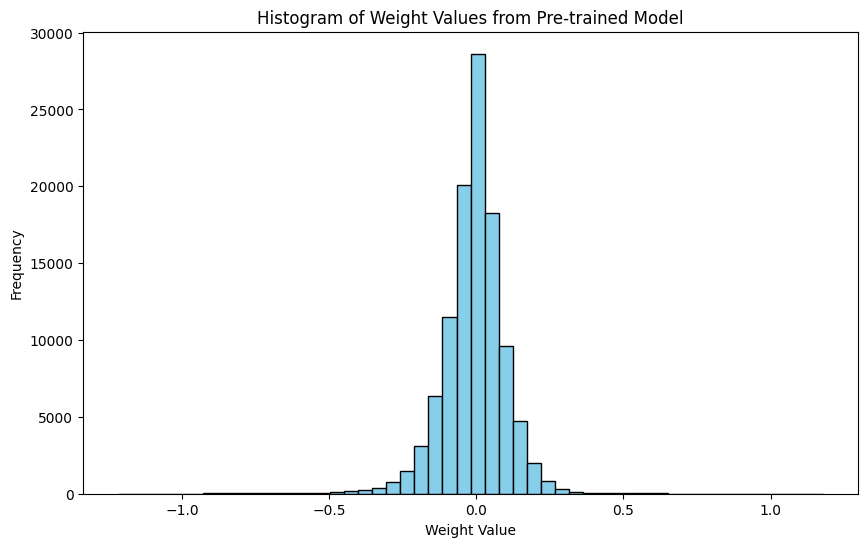

In [20]:
import torch
import matplotlib.pyplot as plt

# Extract weight values from each layer
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:  # We only want weights, not biases
        weights.append(param.data.cpu().numpy().flatten())  # Flatten the weight tensor and move to CPU

# Combine all weight values into one array
weights = torch.cat([torch.tensor(w) for w in weights])

# Plot histogram of weight values
plt.figure(figsize=(10, 6))
plt.hist(weights.numpy(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Weight Values from Pre-trained Model")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()


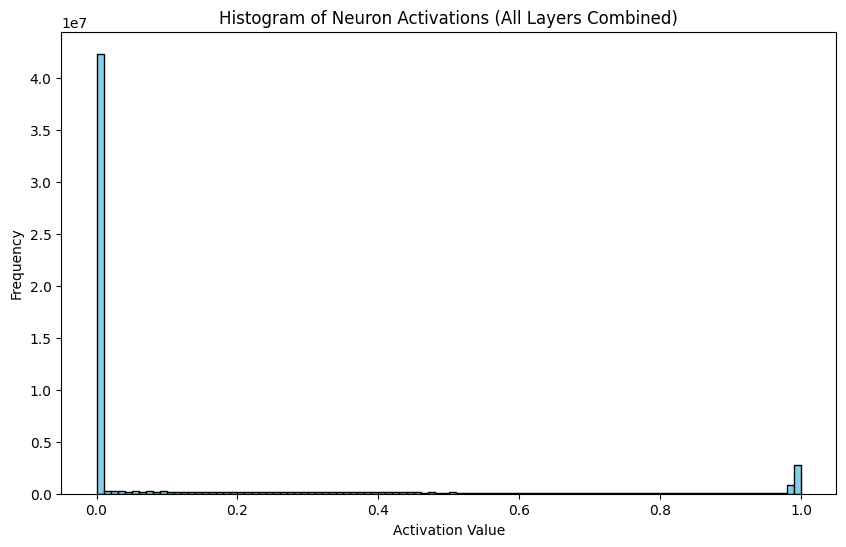

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(784, 128, bias=True)  # Input: 784 → Hidden: 128
        self.l3 = nn.Linear(128, 64, bias=True)   # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10, bias=True)    # Hidden: 64 → Output: 10

    def forward(self, im):
        l1 = im.view(-1, 784) 
        
        # Apply ReLU
        l2 = F.relu(self.l2(l1))
        l3 = F.relu(self.l3(l2))
        
        # Min-Max Normalization: Normalize l1, l2, and l3 between [0,1]
        l1 = (l1 - l1.min(dim=1, keepdim=True).values) / (l1.max(dim=1, keepdim=True).values - l1.min(dim=1, keepdim=True).values + 1e-8)
        l2 = (l2 - l2.min(dim=1, keepdim=True).values) / (l2.max(dim=1, keepdim=True).values - l2.min(dim=1, keepdim=True).values + 1e-8)
        l3 = (l3 - l3.min(dim=1, keepdim=True).values) / (l3.max(dim=1, keepdim=True).values - l3.min(dim=1, keepdim=True).values + 1e-8)
        
        l4 = self.l4(l3)
        return l1, l2, l3, l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load pre-trained weights
model.load_state_dict(torch.load("model_weights.pth"))

# Collect activations from l1, l2, l3, and l4
all_activations = []

# Forward pass through the data
model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        l1, l2, l3, _ = model(images)  # Get activations from l1, l2, l3, and l4
        
        # Flatten and store activations from l1, l2, and l3
        all_activations.append(l1.cpu().numpy().flatten())
        all_activations.append(l2.cpu().numpy().flatten())
        all_activations.append(l3.cpu().numpy().flatten())

# Flatten the list of activations
all_activations = np.concatenate(all_activations)

# Plot the histogram for all layers' activations combined
plt.figure(figsize=(10, 6))
plt.hist(all_activations, bins=100, color="skyblue", edgecolor="black")
plt.title("Histogram of Neuron Activations (All Layers Combined)")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.show()


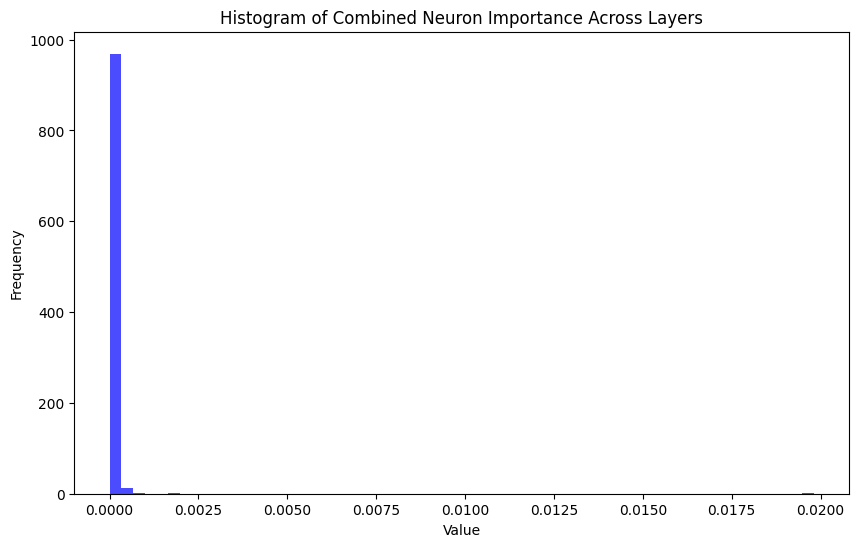

In [27]:
import matplotlib.pyplot as plt

ns = torch.cat((l1, l2, l3, l4))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ns.detach().numpy(), bins=60, color="blue", alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Neuron Importance Across Layers')

# Show the plot
plt.show()